In [ ]:
import os
import requests
from io import BytesIO

import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.image as mpimg
from PIL import Image
import pandas as pd
import seaborn as sns
# from tabulate import tabulate
import sklearn
import pickle
import scprep
import phate
from heatgeo.embedding import HeatGeo
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

os.chdir('../../src')
import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)
import mappings

In [34]:
# define a sweep function of HeatGeo parameters
def sweep_heatgeo(data, labels, knns, taus):
    fig, ax = plt.subplots(nrows=len(knns), ncols=len(taus), figsize=(4*len(knns), 4*len(taus)), gridspec_kw={'wspace': 0.1})
    i_knn = 0
    for knn in knns:
        j_tau = 0
        for tau in taus:
            paras = f'knn: {knn}, tau: {tau}'
            heatgeo_op = HeatGeo(knn=knn, tau=tau, n_pca=None)
            heatgeo_embedding = heatgeo_op.fit_transform(data)

            scprep.plot.scatter2d(heatgeo_embedding, s = 4, cmap = mappings.pop_pallette_1000G_fine, 
                                  c = labels['population'], legend=False, ax = ax[i_knn, j_tau], 
                                  xticks=False, yticks=False, figsize=(10, 6),
                                  label_prefix=None, title=paras, fontsize=6)
            j_tau = j_tau + 1
        i_knn = i_knn + 1 
    plt.show()

# HeatGeo for 1000G 

In [5]:
def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

inputs = load_from_local('../data/1000G/1000G_PCA')
labels = load_from_local('../data/1000G/1000G_labels')
admix_ratios = load_from_local('../data/1000G/1000G_admix_ratios')

In [26]:
knn = 5
tau = 20
n_pca = None
heatgeo_op = HeatGeo(knn=knn, tau=tau, n_pca=n_pca)
heatgeo_embedding = heatgeo_op.fit_transform(inputs)

paras = f'knn: {knn}, tau: {tau}, n_pca: {n_pca}'

Using s_gd2 for MDS. None


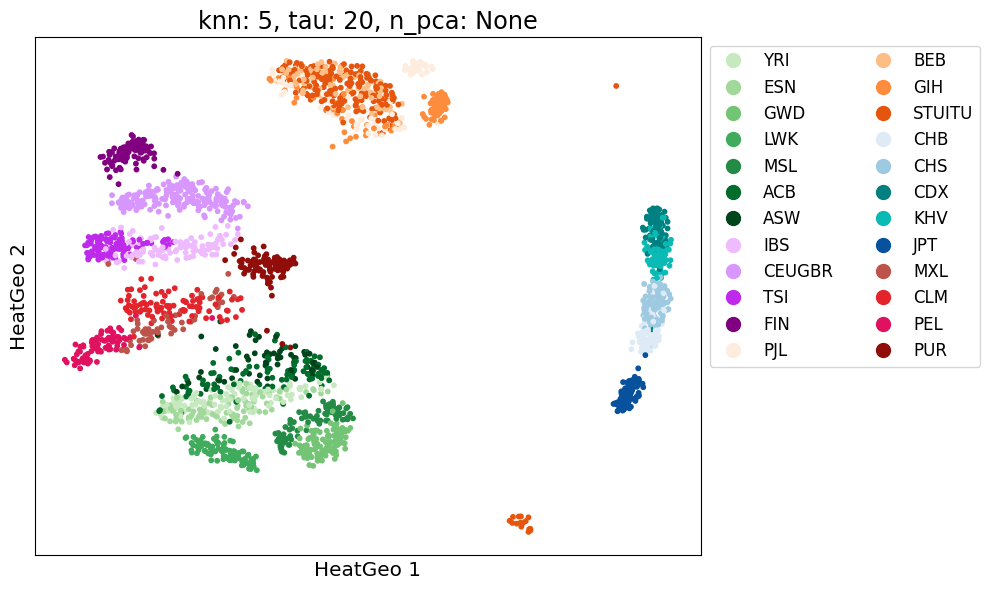

In [25]:
# plot
scprep.plot.scatter2d(heatgeo_embedding, s = 10, cmap = mappings.pop_pallette_1000G_fine, 
                      legend_anchor=(1,1),legend_ncol=2, c = labels['population'], 
                      xticks=False, yticks=False, figsize=(10, 6),
                      label_prefix="HeatGeo ", title=paras, fontsize=10)

plt.show()

Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None
Using s_gd2 for MDS. None


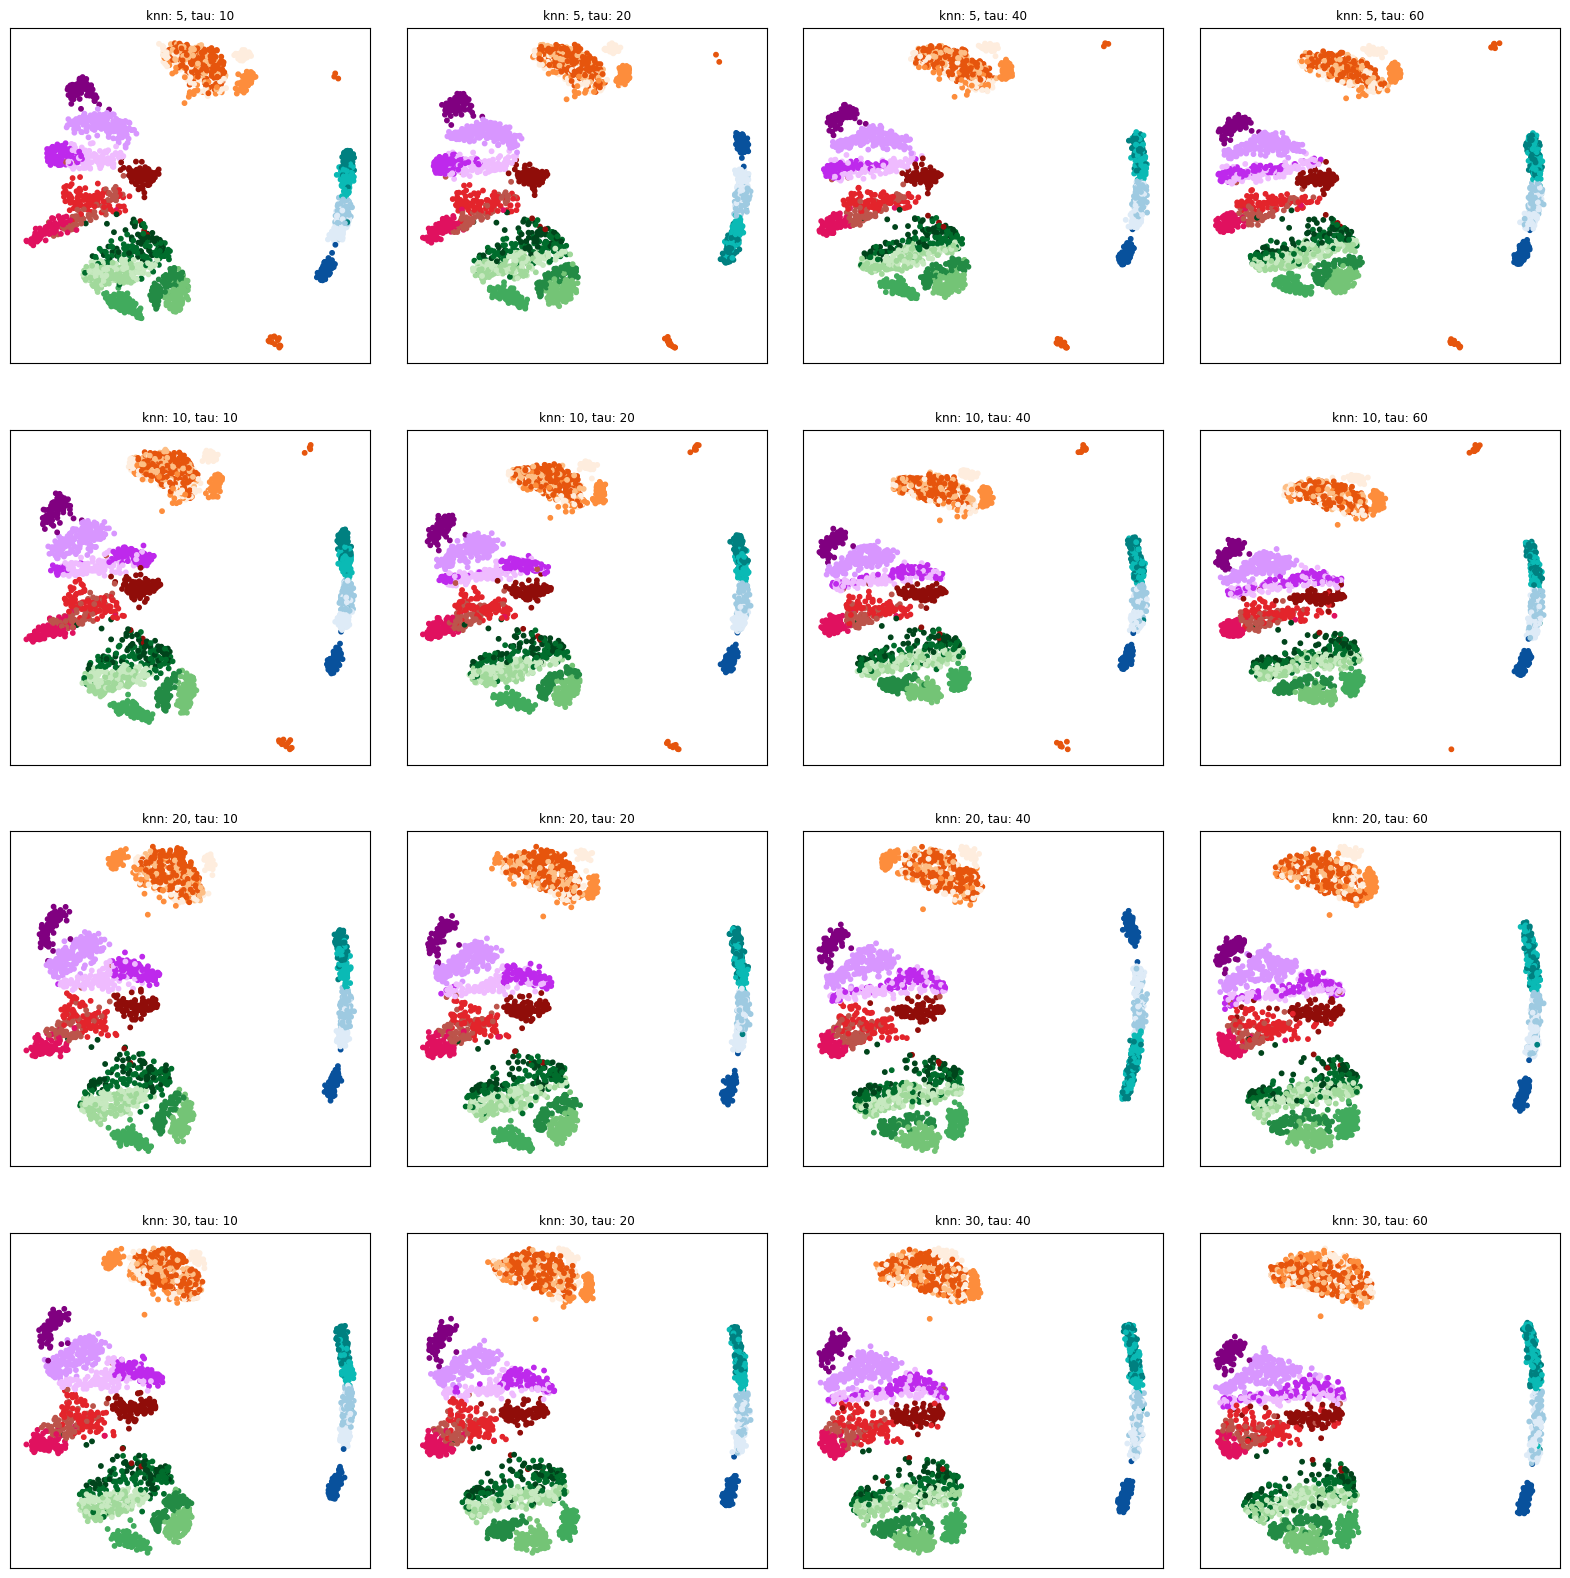

In [32]:
knns = [5, 10, 20, 30]
taus = [10, 20, 40, 60]
sweep_heatgeo(inputs, knns, taus)

# HeatGeo for HGDP

In [45]:
import copy

def make_palette_label_order_HGDP(metadata_labels):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(metadata_labels['superpopulation']):
        for pop in np.unique(metadata_labels['population'][metadata_labels['superpopulation']==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(metadata_labels['superpopulation']):
        for pop in np.unique(metadata_labels['population'][metadata_labels['superpopulation']==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

In [46]:
pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(labels)

In [47]:
def load_from_local(fpath):
    # Load into a DataFrame
    df = pd.read_csv(fpath)
    df.set_index('Unnamed: 0', inplace=True)
    return df    

HGDP_PCA = load_from_local('../data/HGDP/HGDP_PCA')
HGDP_labels = load_from_local('../data/HGDP/HGDP_labels')
HGDP_admix_ratios = load_from_local('../data/HGDP/HGDP_admix_ratios')

In [48]:
knn = 5
tau = 20
n_pca = None
heatgeo_op = HeatGeo(knn=knn, tau=tau, n_pca=n_pca)
heatgeo_embedding = heatgeo_op.fit_transform(HGDP_PCA)

paras = f'HGDP: knn: {knn}, tau: {tau}'

Using s_gd2 for MDS. None


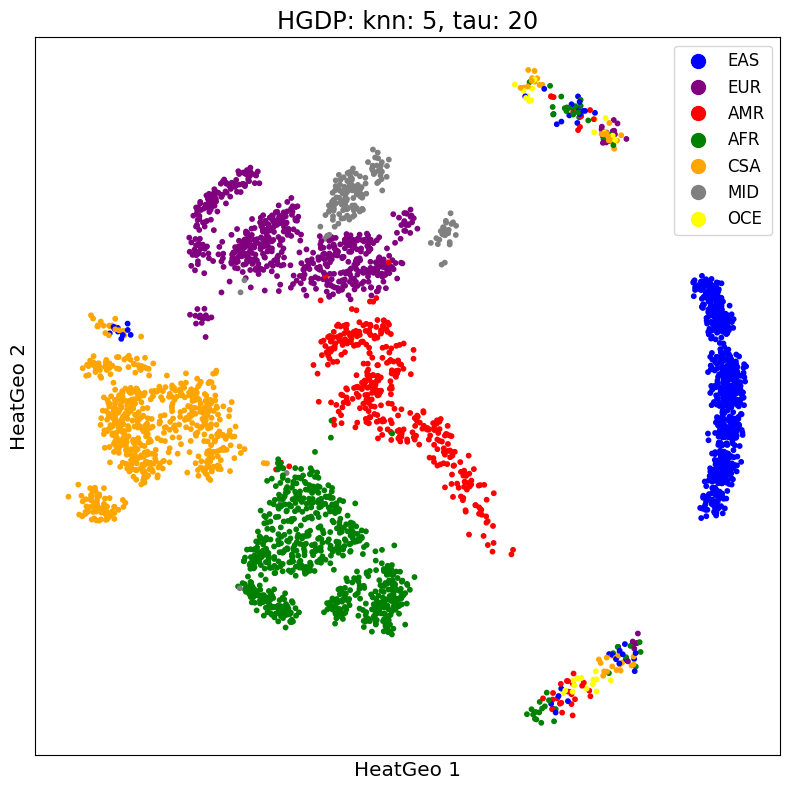

In [59]:
# plot
scprep.plot.scatter2d(heatgeo_embedding, s = 10, cmap = pop_palette_hgdp_coarse, 
                      legend_anchor=(1,1),legend_ncol=1, c = HGDP_labels['superpopulation'], 
                      xticks=False, yticks=False, figsize=(8, 8),
                      label_prefix="HeatGeo ", title=paras, fontsize=10)

plt.show()